In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import matplotlib.ticker as ticker
import pandas_profiling
from sklearn.neighbors import KernelDensity

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# EDA

In [ ]:
# Load datasets
train = pd.read_csv('./datasets/cleaned_train.csv')
test = pd.read_csv('./datasets/test.csv')
weather = pd.read_csv('./datasets/cleaned_weather.csv')
spray = pd.read_csv('./datasets/spray.csv')

In [ ]:
merged_df = pd.merge(weather, train, on=['Date', 'Year', 'Week', 'Month', 'DayOfWeek'])

In [ ]:
#pandas_profiling.ProfileReport(train)

In [ ]:
# use heatmap to find the correlation
def heatmap(df):
    fix, ax = plt.subplots(figsize=(22,22))

    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    ax = sns.heatmap(df.corr(), mask=mask, ax=ax, cmap='coolwarm',vmin=-1, vmax=1,
                     square=True, linewidth=1,annot=True,annot_kws={'size':'13'},
                     cbar_kws={"shrink": 0.8}, fmt='.1g',center=0)

    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

    ax.set_title('Correlation Heatmap for Merged Data', fontsize=22);

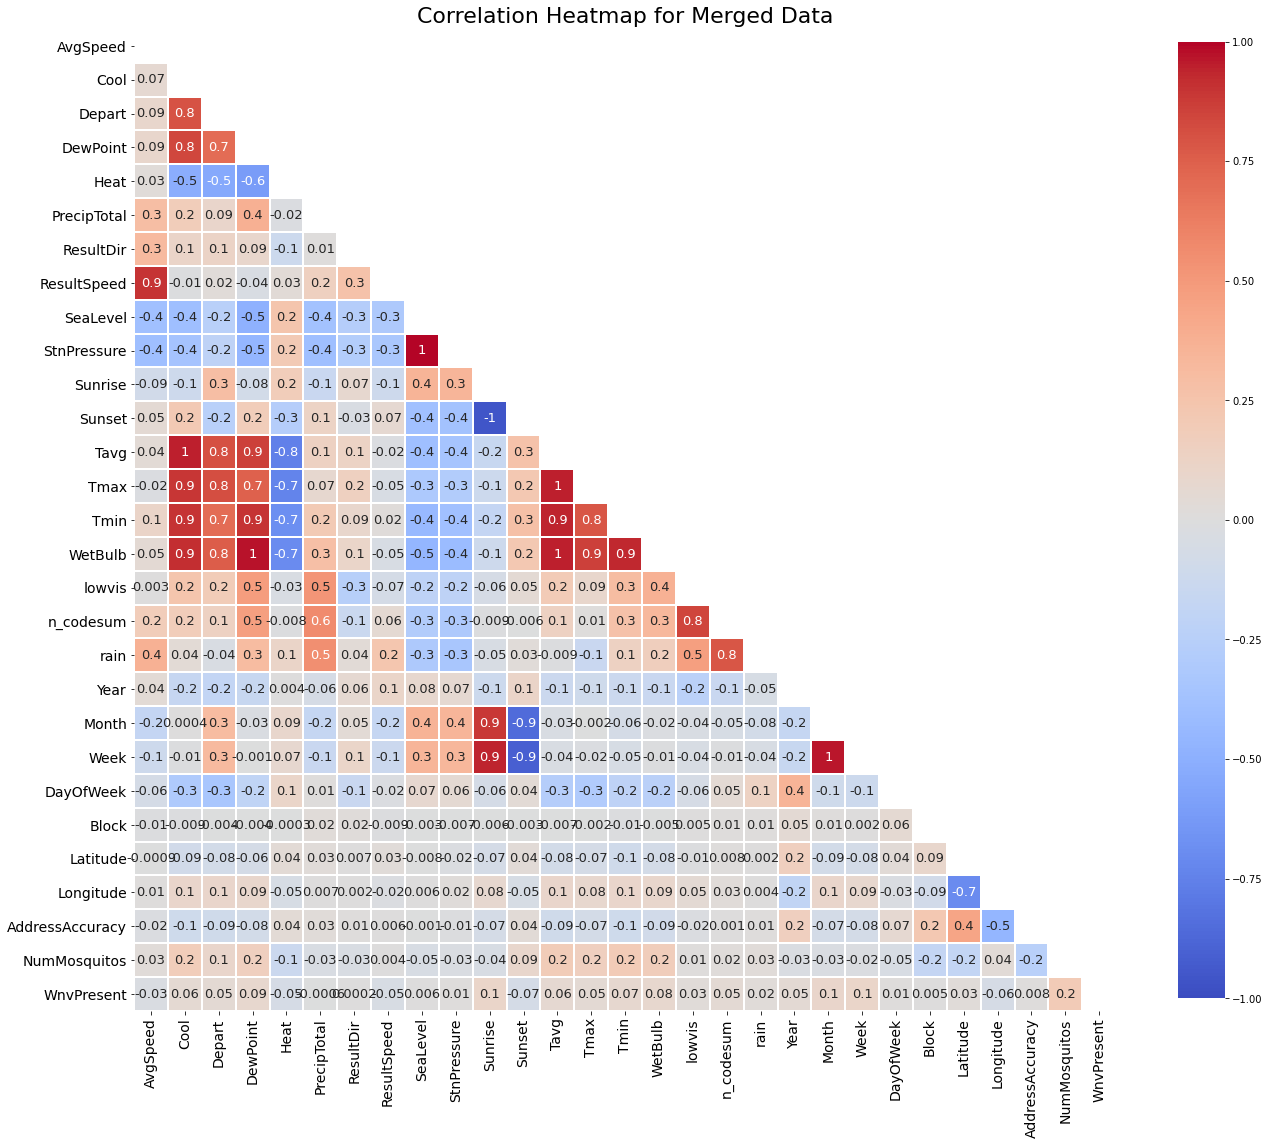

In [ ]:
heatmap(merged_df)

From the heatmap above, all our features are generally have a very low correlation to `WnvPresent` (target variable). There are a lot of the multicollinearity whereby the predictor variables have very high correlation between each other. 

Due to the low correlation of the predictor variable to the target variable, we will perform the feature engineering process by constructing new features from existing predictor variables.

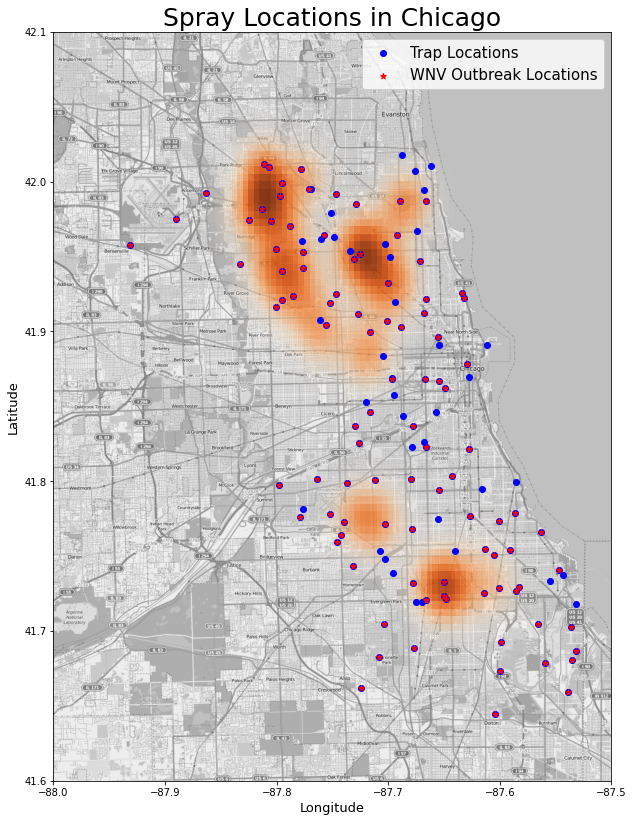

In [ ]:
alpha_cm = plt.cm.Oranges
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]

lon_lat_box = (-88, -87.5, 41.6, 42.1)

# Spray location
X = spray[['Longitude', 'Latitude']].drop_duplicates().values
kd = KernelDensity(bandwidth=0.015)
kd.fit(X)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))

#kernel density
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
plt.imshow(zv, origin='lower', cmap=alpha_cm, extent=lon_lat_box, aspect=aspect)

# trap locations
trap_locations = train[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(trap_locations[:,0], trap_locations[:,1], marker='o', c='b', label='Trap Locations')

# wnn outbreak locations
wnv_locations = train[train['WnvPresent'] != 0][['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(wnv_locations[:,0], wnv_locations[:,1], marker='*', c='r', label='WNV Outbreak Locations')

plt.title('Spray Locations in Chicago', fontsize=25)
plt.legend(fontsize=15)
plt.xlabel('Longitude', fontsize=13)
plt.ylabel('Latitude', fontsize=13)
plt.savefig('Spray Locations.png')

We wanted to get a better visual of what our data was telling us geographically. The green circles are where the weather stations located, the blue circles indicate the location of the traps placed for catching mosquitoes, the red stars indicate the location of the WNV outbreak and the orange markings describe the areas that were sprayed. Area with the darker orange indicates that the region has more spray concentration area and the area with lighter orange means that less spray concentration area.

From the map, we have discovered that all the traps are spread out well geographically, however the spraying fails to fully overlap with the virus outbreak. This is a cause for concern and can be because of multiple reasons eg - improper spraying practices. We will explore this further in the modelling and cost benefit analysis.

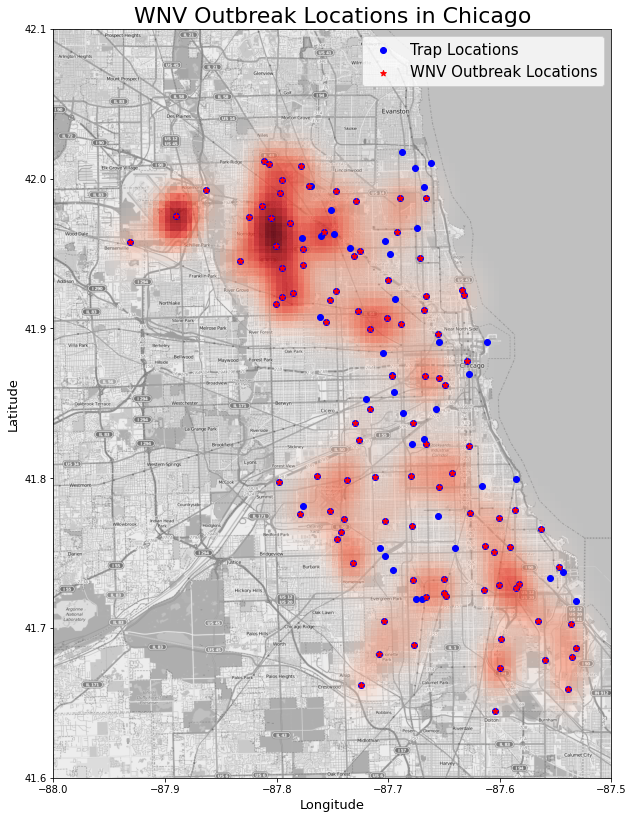

In [ ]:
alpha_cm1 = plt.cm.Reds
alpha_cm1._init()
alpha_cm1._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm1.N) / 10 - 1)[::-1]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]

lon_lat_box = (-88, -87.5, 41.6, 42.1)

#Traps where only WNV is present
wnv = train[train['WnvPresent'] == 1]
wnv = wnv.groupby(['Date', 'Trap','Longitude', 'Latitude']).max()['WnvPresent'].reset_index()
X1 = wnv[['Longitude', 'Latitude']].values
kd1 = KernelDensity(bandwidth=0.015)
kd1.fit(X1)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv1 = np.exp(kd1.score_samples(gridpoints).reshape(100,100))

#kernel density
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
plt.imshow(zv1, origin='lower', cmap=alpha_cm1, extent=lon_lat_box, aspect=aspect)

# trap locations
trap_locations = train[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(trap_locations[:,0], trap_locations[:,1], marker='o', c='b', label='Trap Locations')

# wnn outbreak locations
wnv_locations = train[train['WnvPresent'] != 0][['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(wnv_locations[:,0], wnv_locations[:,1], marker='*', c='r', label='WNV Outbreak Locations')

plt.title('WNV Outbreak Locations in Chicago', fontsize = 22)
plt.legend(fontsize=15)
plt.xlabel('Longitude', fontsize=13)
plt.ylabel('Latitude', fontsize=13)
plt.savefig('WNV Outbreak Locations.png')

This map helps to identify the density of the traps carrying mosquitoes with WNV. Area with the darker red indicates that the region has more mosquitoes that carry the WNV and the area with lighter red means that less virus density area. The map help with indicating which areas have a higher priority when it comes to anti WNV sprays.

                        NumMosquitos  WnvPresent
Species                                         
CULEX ERRATICUS                    7           0
CULEX PIPIENS                  44671         240
CULEX PIPIENS/RESTUANS         66268         262
CULEX RESTUANS                 23431          49
CULEX SALINARIUS                 145           0
CULEX TARSALIS                     7           0
CULEX TERRITANS                  510           0


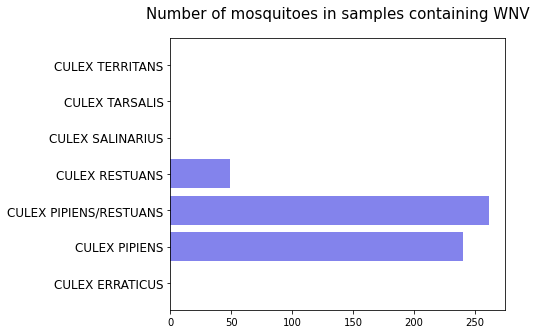

In [ ]:
mos_wnv = train[['Species', 'NumMosquitos', 'WnvPresent']].groupby(by='Species').sum()
print(mos_wnv)

# reset the index after groupby
mos_wnv.reset_index(inplace=True)

plt.figure(figsize=(6,5))
plt.barh(mos_wnv['Species'], mos_wnv['WnvPresent'], color='#8383EC')
plt.title('Number of mosquitoes in samples containing WNV', fontsize=15, y=1.05)
plt.yticks(fontsize=12)
plt.show()

From the table and graph above, we can see that Culex Pipiends and Culex Restuans are the most captured mosquitos and the only mosquitos that will carry West Nile Virus, about 0.4 % of the total samples are carrying the virus. Thus, we will be focusing on both mosquitos' activities.

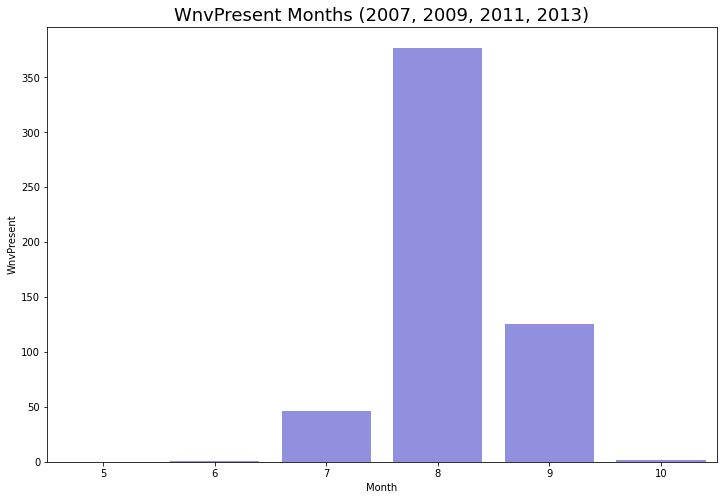

In [ ]:
# August tends to have higher incidences of the West Nile Virus
fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.barplot(data=train.groupby(by='Month').sum().reset_index(), x='Month', y='WnvPresent', color='#8383EC', ax=ax)
plt.title('WnvPresent Months (2007, 2009, 2011, 2013)', fontsize=18);

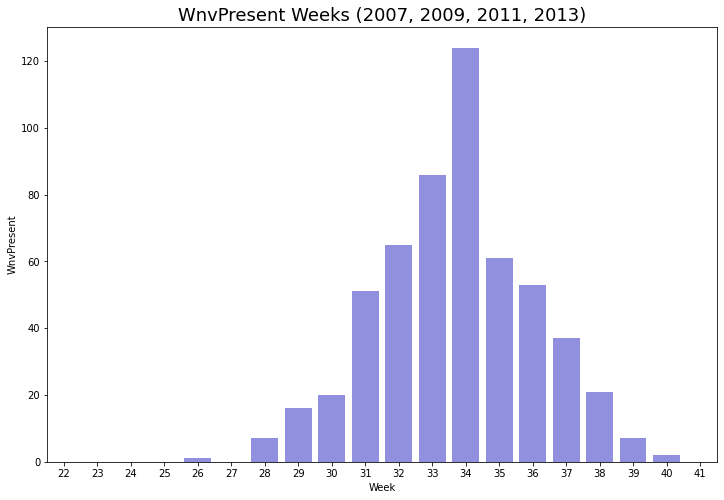

In [ ]:
# Weeks 33-34 tend to have higher incidences of the West Nile Virus
fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.barplot(data=train.groupby(by='Week').sum().reset_index(), x='Week', y='WnvPresent', color='#8383EC', ax=ax)
plt.title('WnvPresent Weeks (2007, 2009, 2011, 2013)', fontsize=18);

From the months graph above, we can see that the WNV cases started from July till and reduced in September, which is the summer season in Chicago. 

When we look into the weeks graph, we can see that the WNV cases started from week 26 (between end June and early July) and decreased at week 40 (between end September and early October). Week 34 (around mid August) has the highest cases every year. 

Our first instinct from this information that most of the WNV cases happened around summer time must be related to the weather which encouraging mosquitoes breeding. We will look into the weather information later.

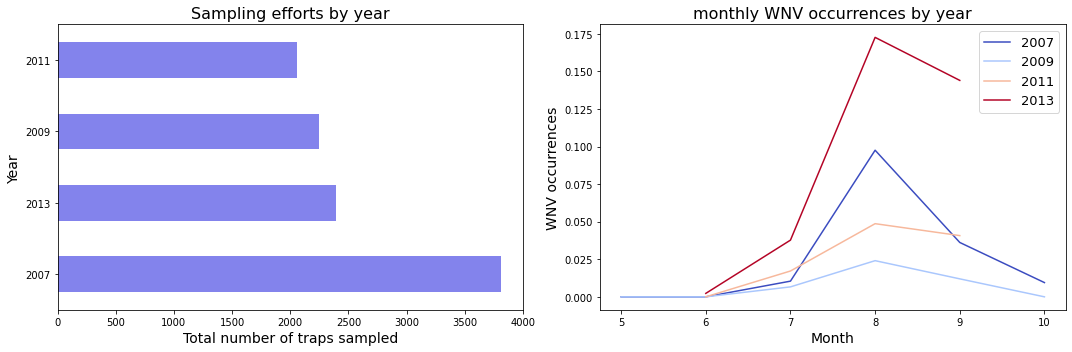

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize=(15,5))

# plot sampling efforts by year
train['Year'].value_counts().plot(kind = 'barh', ax = ax[0], color='#8383EC')
ax[0].set_title('Sampling efforts by year', fontsize=16)
ax[0].set_ylabel('Year', fontsize=14)
ax[0].set_xlabel('Total number of traps sampled',fontsize=14)

sns.lineplot(data = train, x='Month', y='WnvPresent', hue='Year', ci = None, 
             palette = 'coolwarm', ax = ax[1])
ax[1].legend(fontsize = 13)
ax[1].set_title('monthly WNV occurrences by year', fontsize=16)
ax[1].set_xlabel('Month',fontsize=14)
ax[1].set_ylabel('WNV occurrences',fontsize=14)

plt.tight_layout()

The bar chart on the left shows the total number of the traps being planned each year seems like Chicago government has reduced the amount of the traps since 2017 maybe due to too much of traps did not trap the mosquitoes with WNV.

Line graph on the right shows the density of the monthly WNV cases each year. We can see that August is the peak moment for the WNV occurrences every year and 2013 has the highest occurences of WNV present in the sample.

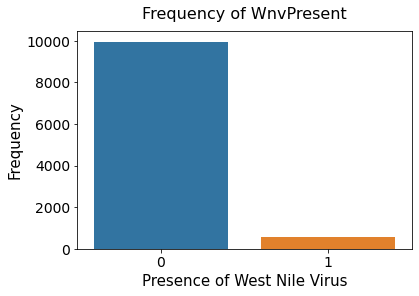

In [ ]:
# The target is imbalanced, which will be taken care of before modelling is done.
sns.barplot(x=[0,1], y=train['WnvPresent'].value_counts())
plt.xlabel('Presence of West Nile Virus', fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.tick_params(labelsize=14)
plt.title('Frequency of WnvPresent',fontsize=16, y=1.03)
plt.show()

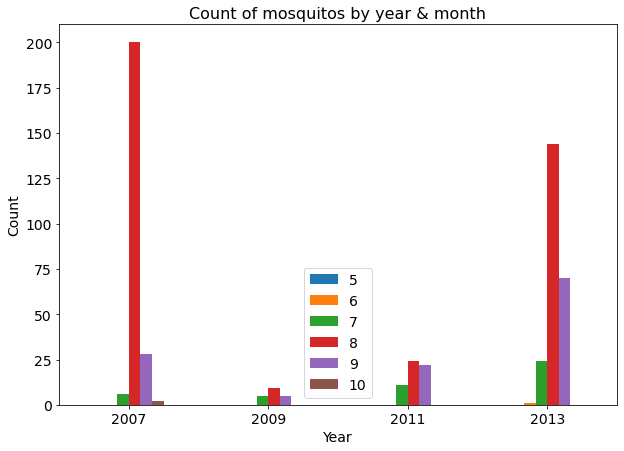

In [ ]:
train.groupby(['Year','Month'])['WnvPresent'].sum().unstack().plot.bar(figsize=(10,7))
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Count of mosquitos by year & month', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.legend(fontsize=14)
plt.show()

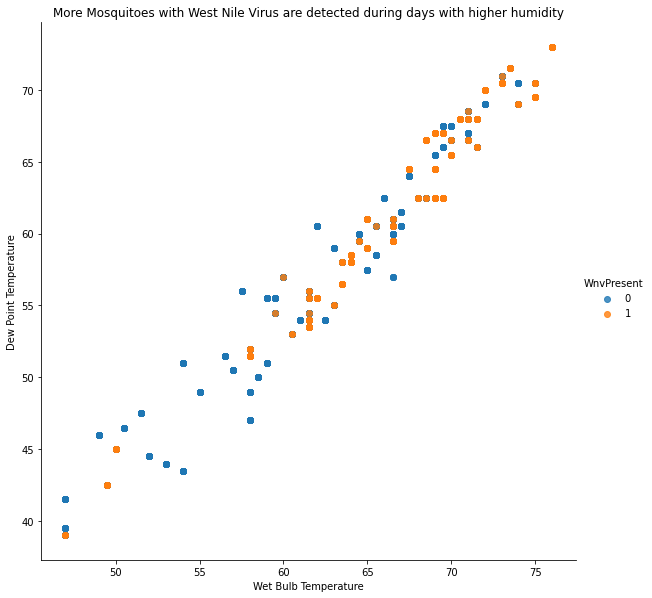

In [ ]:
sns.lmplot( x='WetBulb', y='DewPoint', data=merged_df, fit_reg=False, hue='WnvPresent', height=8)
plt.title('More Mosquitoes with West Nile Virus are detected during days with higher humidity')
plt.xlabel('Wet Bulb Temperature')
plt.ylabel('Dew Point Temperature');

When the wet bulb temperature exceeds 59 degrees Fahrenheit and dew point temperature exceeds 50 degrees Fahrenheit, it will create a humid environment that is important to the mosquito's activities. Thus, we can see the more mosquitoes with WNV are detected.

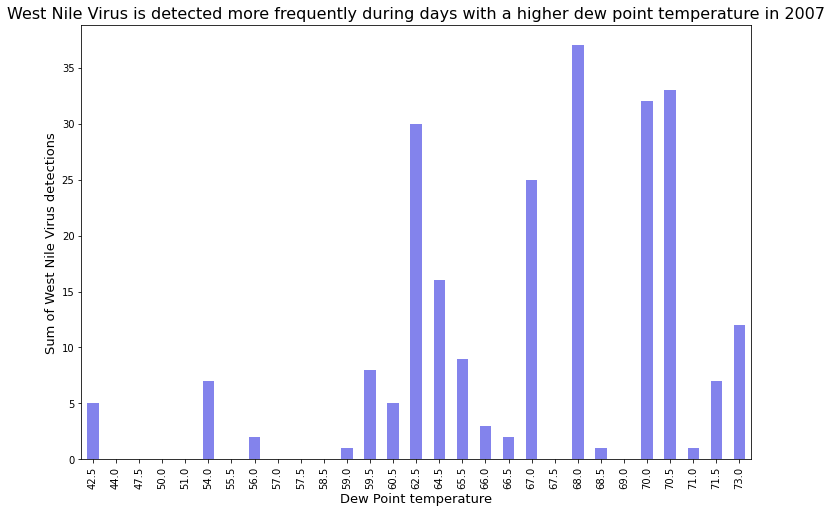

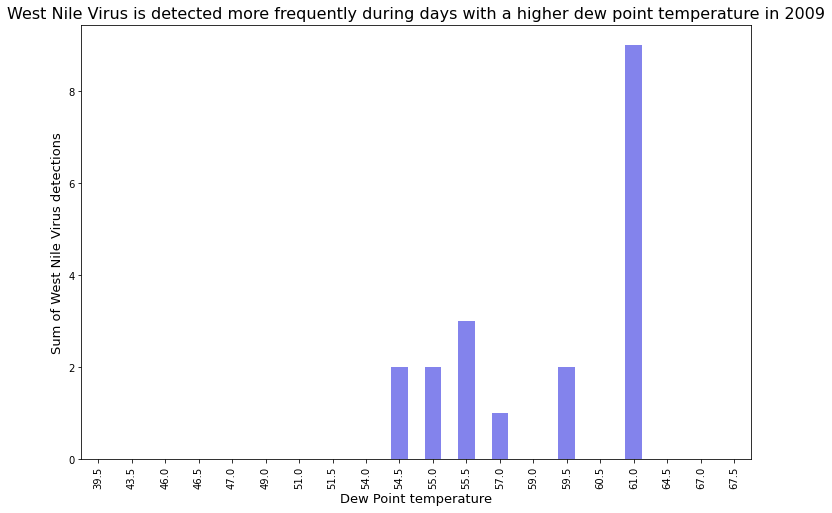

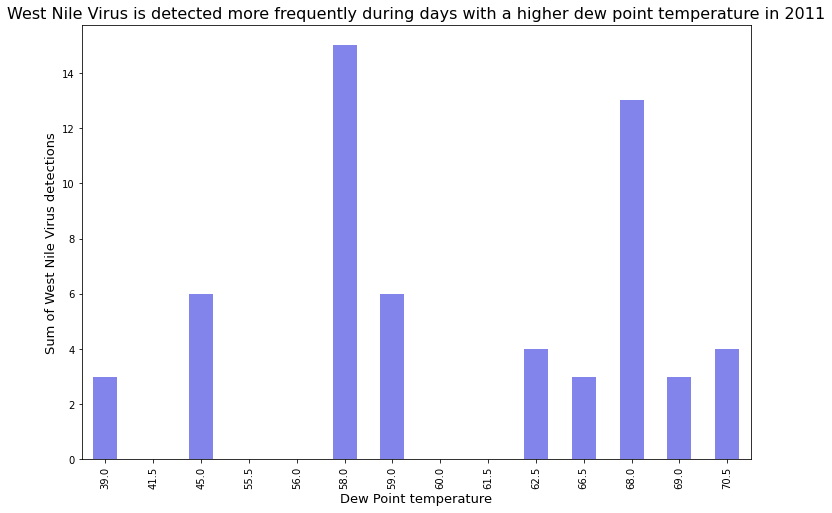

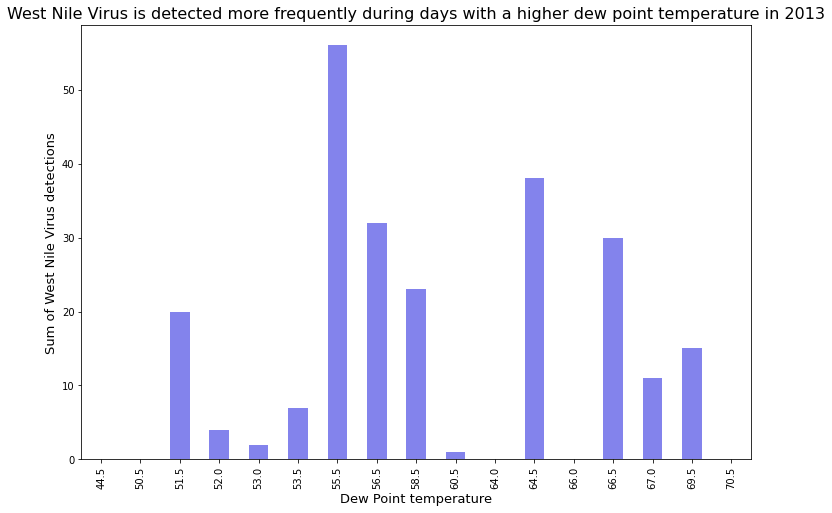

In [ ]:
for x in merged_df['Year'].unique():
    plt.figure(figsize=(12,8))
    merged_df[merged_df['Year']==x].groupby(['DewPoint'])['WnvPresent'].sum().plot.bar(color='#8383EC') 
    plt.title(f"West Nile Virus is detected more frequently during days with a higher dew point temperature in {x}", fontsize=16)
    plt.xlabel("Dew Point temperature", fontsize =13)
    plt.xticks(rotation=90)
    plt.ylabel("Sum of West Nile Virus detections", fontsize=13)

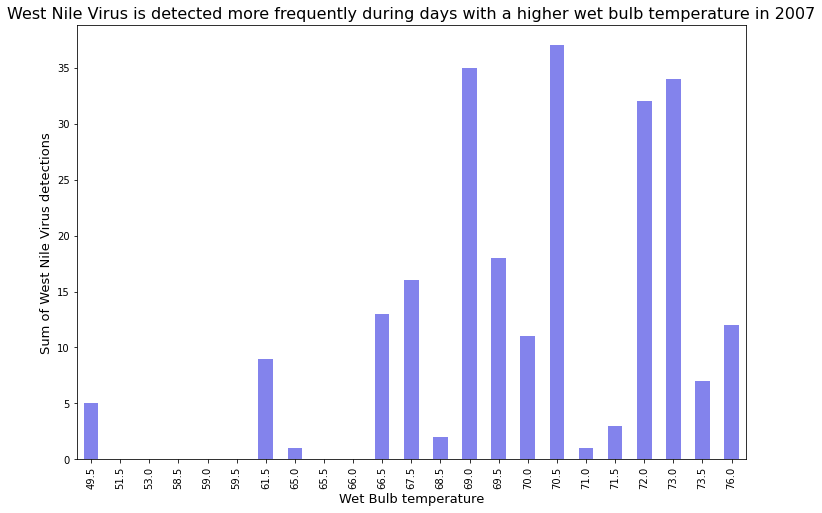

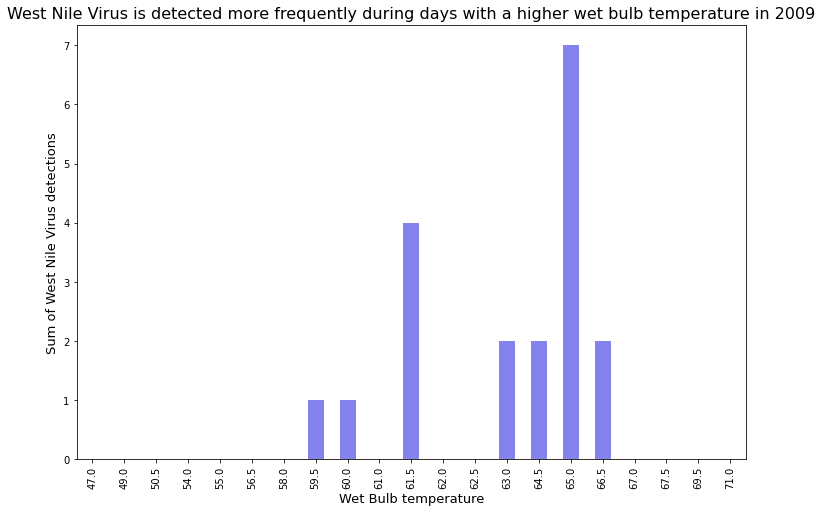

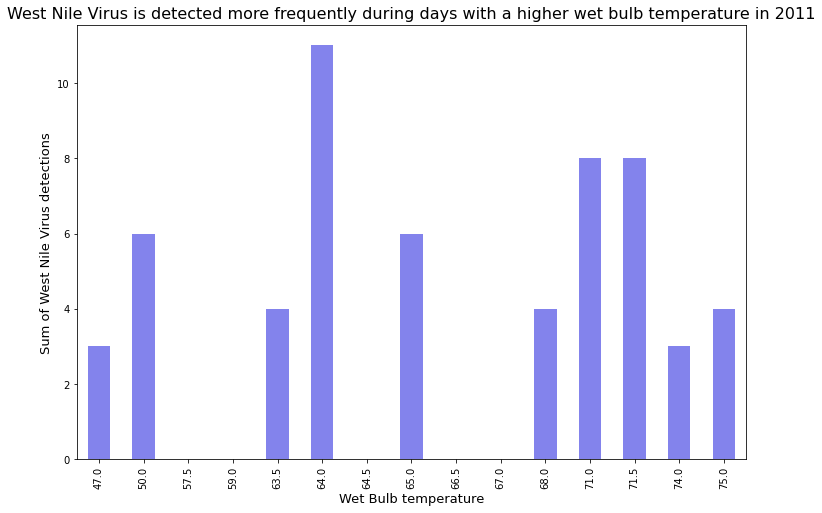

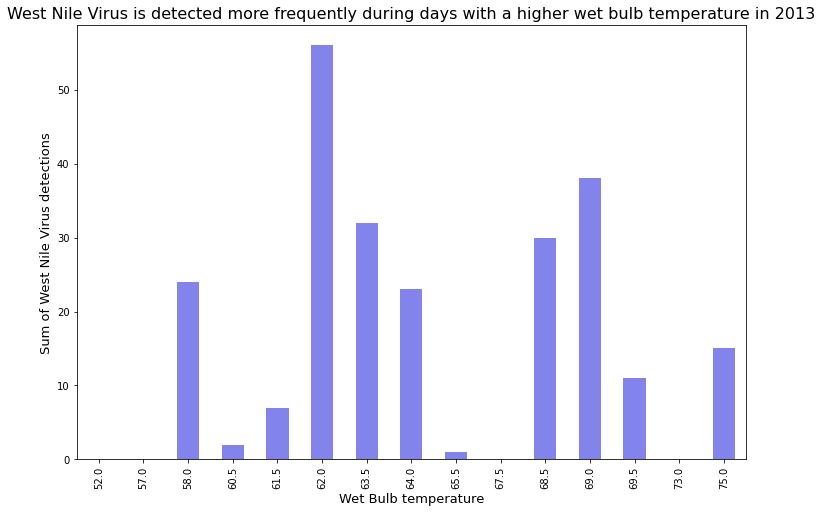

In [ ]:
for x in merged_df['Year'].unique():
    plt.figure(figsize=(12,8))
    merged_df[merged_df['Year']==x].groupby(['WetBulb'])['WnvPresent'].sum().plot.bar(color='#8383EC') 
    plt.title(f"West Nile Virus is detected more frequently during days with a higher wet bulb temperature in {x}", fontsize=16)
    plt.xlabel("Wet Bulb temperature", fontsize =13)
    plt.xticks(rotation=90)
    plt.ylabel("Sum of West Nile Virus detections", fontsize=13)

When we look at the relationship between wet bulb temperature/ dew point temperature vs WNV present individually, we can see that there is a range showing that the WNV detected:
- wet bulb temperature - between 59 to 76 degrees Fahrenheit
- dew point temperature - between 59 to 76 degrees Fahrenheit

## Temperature

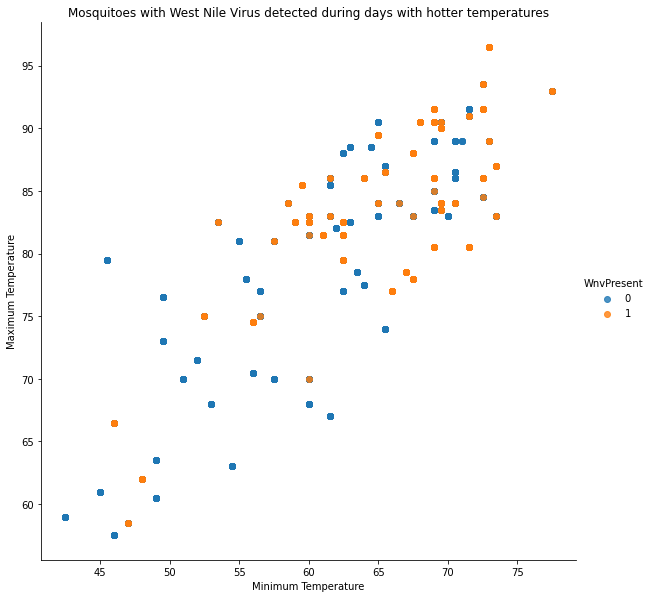

In [ ]:
sns.lmplot( x='Tmin', y='Tmax', data=merged_df, fit_reg=False, hue='WnvPresent', height=8)
plt.title('Mosquitoes with West Nile Virus detected during days with hotter temperatures')
plt.xlabel('Minimum Temperature')
plt.ylabel('Maximum Temperature');

It's well known that mosquitoes love warm climates. From the scatter plot, we can see that most of the WVN cases happened when the days with the temperature above 55 degrees Fahrenheit.

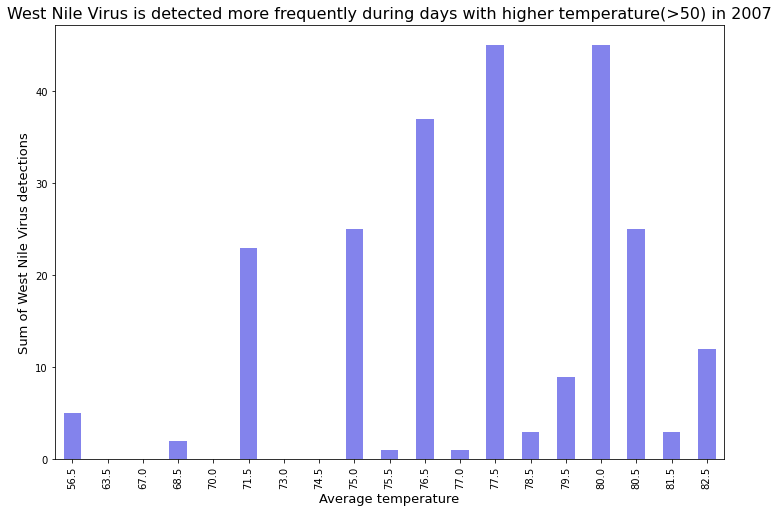

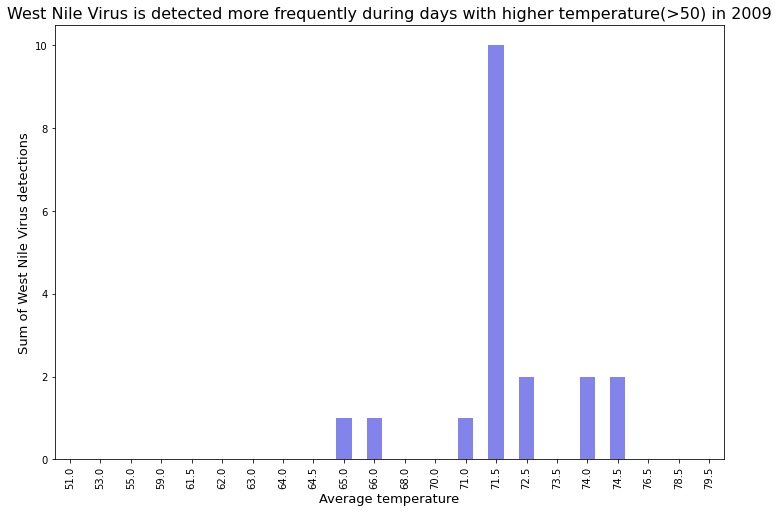

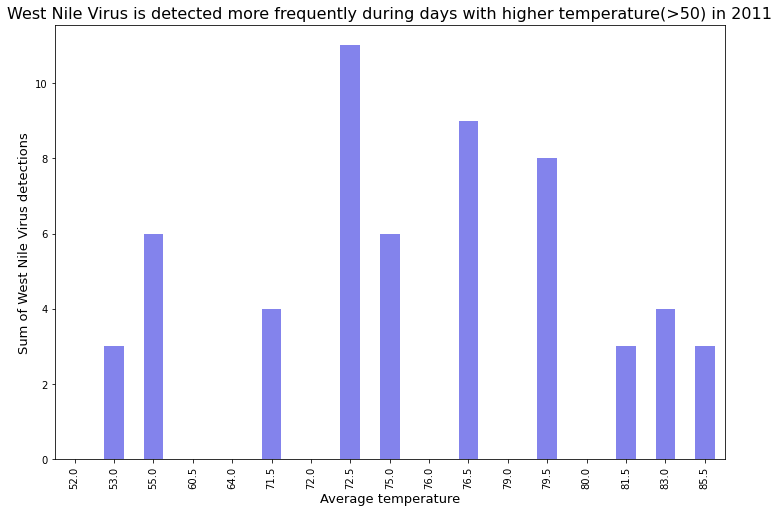

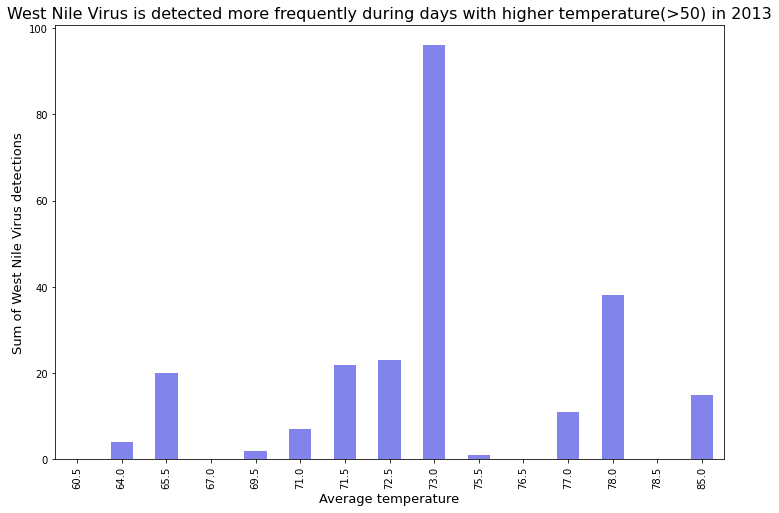

In [ ]:
for x in merged_df['Year'].unique():
    plt.figure(figsize=(12,8))
    merged_df[merged_df['Year']==x].groupby(['Tavg'])['WnvPresent'].sum().plot.bar(color='#8383EC') 
    plt.title(f"West Nile Virus is detected more frequently during days with higher temperature(>50) in {x}", fontsize=16)
    plt.xlabel("Average temperature", fontsize =13)
    plt.xticks(rotation=90)
    plt.ylabel("Sum of West Nile Virus detections", fontsize=13)

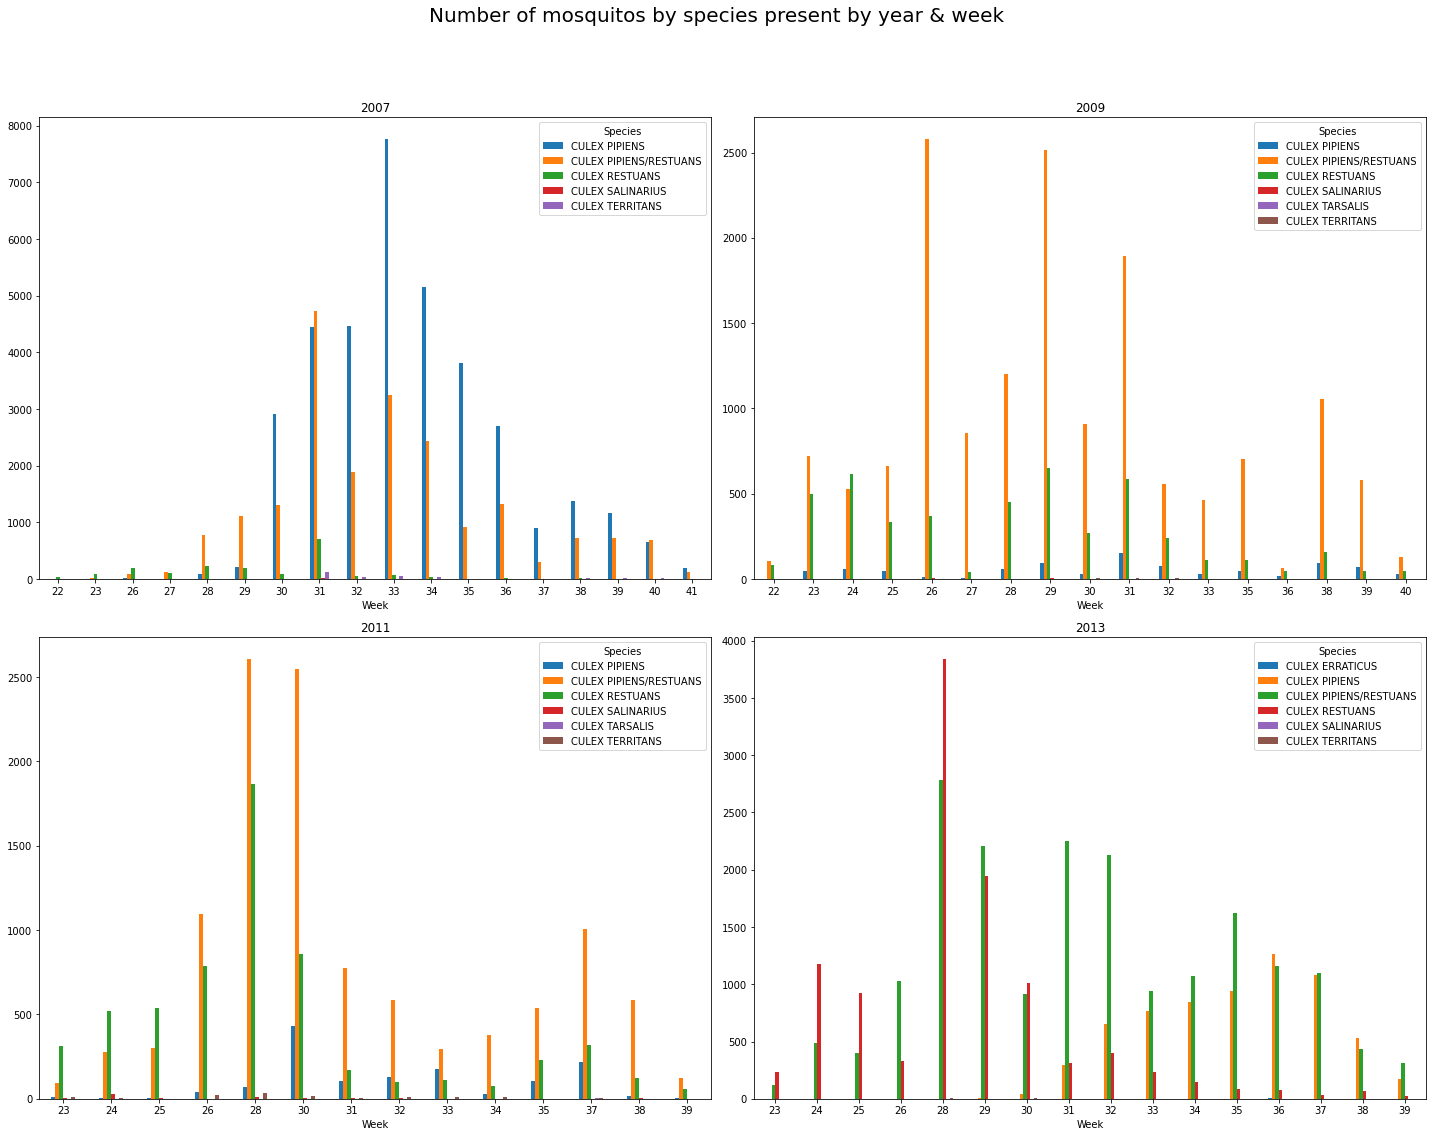

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
ax = ax.ravel()
plt.suptitle('Number of mosquitos by species present by year & week', fontsize=20, y=1.05)
for i, y in enumerate(train['Year'].unique()):
    train[train['Year']==y].groupby(['Week','Species'])['NumMosquitos'].sum().unstack(fill_value=0).plot.bar(ax=ax[i])
    ax[i].set_title(y)
    ax[i].tick_params(axis='x', labelrotation=0)
plt.tight_layout()

The plots above shows the distribution of number of mosquitoes (by species) between the period of Week 22 - 41 in the years 2007, 2009, 2011 and 2013.

- The number of mosquitoes in 2011 is the highest amongst the rest, with the peak at over 7000 mosquitoes in a month.
- The number of mosquitoes increases from week 23 and generally peaks at week 28 - 33


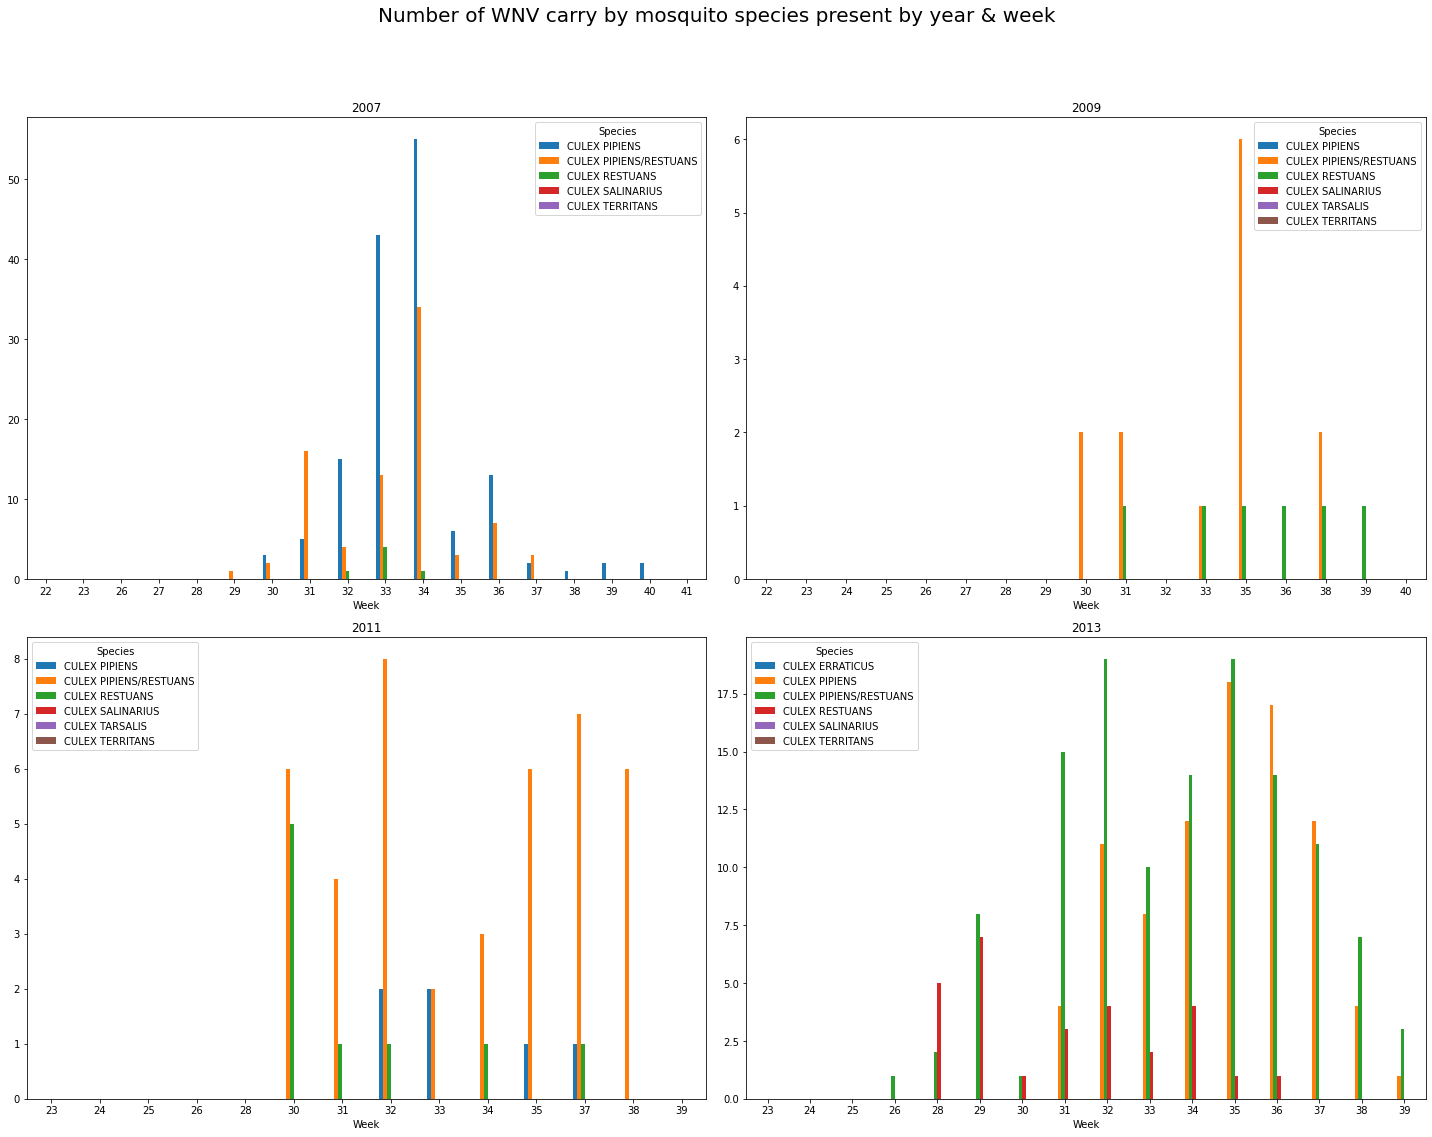

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
ax = ax.ravel()
plt.suptitle('Number of WNV carry by mosquito species present by year & week', fontsize=20, y=1.05)
for i, y in enumerate(train['Year'].unique()):
    train[train['Year']==y].groupby(['Week','Species'])['WnvPresent'].sum().unstack(fill_value=0).plot.bar(ax=ax[i])
    ax[i].set_title(y)
    ax[i].tick_params(axis='x', labelrotation=0)
plt.tight_layout()

The plots above shows the distribution of the WNV carry by mosquito species between the period of Week 26 - 40 in the 2007, 2009, 2011 and 2013.

- In 2007 and 2013, we can see that Culex Pipiens is the species that carry the WNV most.
- Only 3 mosquito species are detected with the WNV
- We notice a lag in the week that the WNV was present as the numbers spikes at Week 26 onwards
- It generally peaks at Weeks 32 - 36

In [ ]:
def twin_bar_plot(fea1, fea2):
    for yr in merged_df['Year'].unique():
        fig, ax1 = plt.subplots(figsize=(12,6))
        
        kwargs = {'alpha':0.5}
        sns.barplot(x=merged_df[merged_df['Year']==yr]['Month'], y=merged_df[merged_df['Year']==yr][fea1]*100,
                     ci=None, color='#8383EC', label=f'{fea1}', ax=ax1)
        ax1.set_xlabel('Month', fontsize=13)
        ax1.set_ylabel(f'{fea1} (%)', fontsize=13, color='#8383EC')
        ax1.legend(loc=2)
        ax1.set_xticklabels(ax1.get_xticklabels());

        no_mosquito = merged_df[merged_df['Year']==yr].groupby(['Month'])[fea2].sum()
        df_no_mosquito = pd.DataFrame(no_mosquito)

        ax2 = ax1.twinx()
        sns.barplot(x=df_no_mosquito.index, y=df_no_mosquito[fea2],
                     ci=None, color='r', label=f'{fea2}', ax=ax2, **kwargs)
        ax2.set_ylabel(f'{fea2}', fontsize=13, color='r')
        ax2.legend(loc=1)

        plt.title(f'{fea1} and {fea2} in {yr}')

        fig.tight_layout()

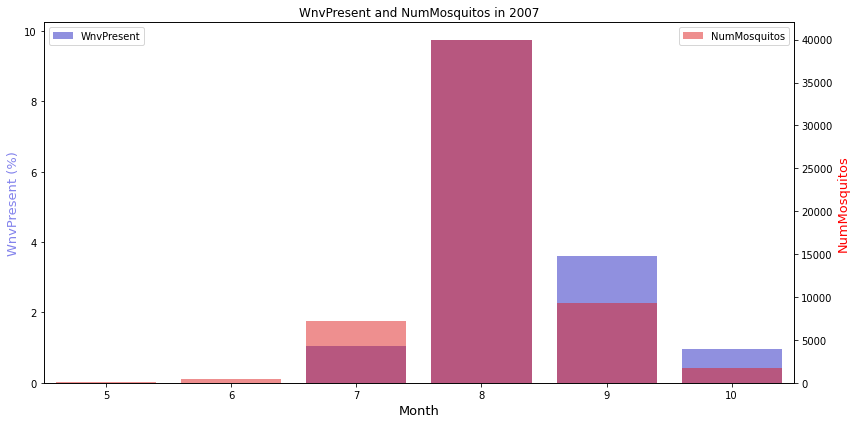

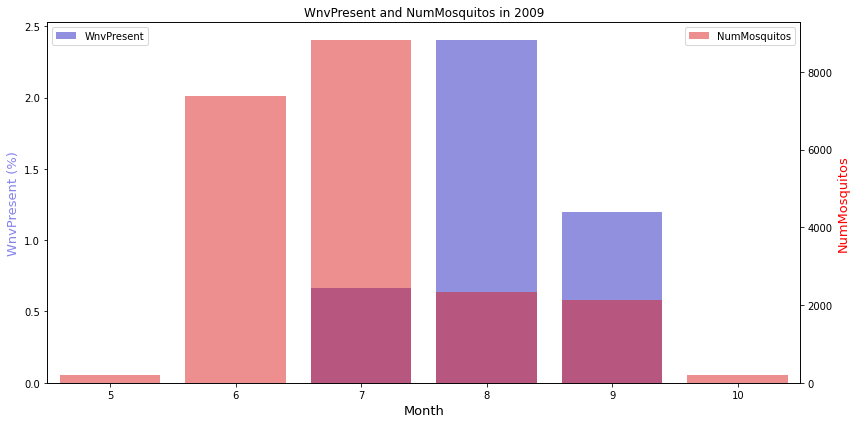

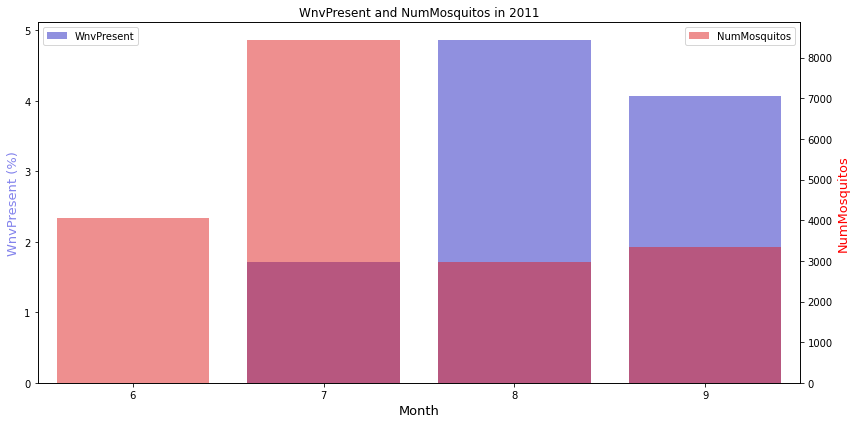

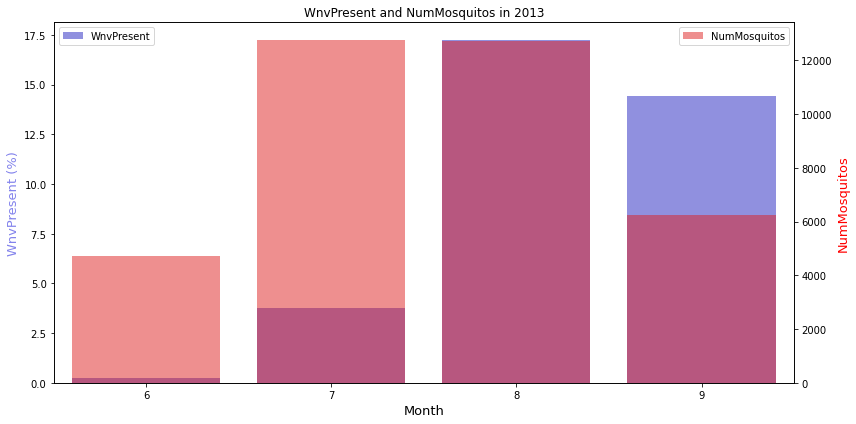

In [ ]:
twin_bar_plot('WnvPresent', 'NumMosquitos')

When we look at the relationship between the number of mosquitoes and the presence of WNV in them, there might not be a clear correlation to between presence of WNV to the number of mosquitoes.

We could then infer other that there are other direct causes to this. For example, we understand that the main carriers of WNV are birds and mosquitoes are simply a medium for which the WNV is being transmitted.

It is no surprise that the number of mosquitoes would not directly affect the presence of WNV.

In [ ]:
spray['Year'] = pd.to_datetime(spray['Date']).apply(lambda x: x.year)
spray['Week'] = pd.to_datetime(spray['Date']).apply(lambda x: x.week)
merged_df = pd.merge(weather, train, on=['Date', 'Year', 'Week', 'Month', 'DayOfWeek'])
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

In [ ]:
def target_plot(target, color):
    for year in [2011, 2013]:
        fig, ax1 = plt.subplots(figsize=(10,4))
        temp_df = merged_df[merged_df['Year']==year].groupby(['Week'])[target].sum().to_frame()

        sns.lineplot(x=temp_df.index, y=temp_df[target],
                     ci=None, color=color, label=f'{target}', ax=ax1)
        ax1.set_ylabel(f'{target}', fontsize=13)
        ax1.legend(loc=1)
        
        if year in spray['Year'].unique():
            for date in spray[spray['Year'] == year].groupby('Week').mean().index:
                plt.axvline(date, linestyle='--', color='black', alpha=0.5, label='Spray')
        
        plt.legend([f'{target}', 'Spray'])
        plt.title(f'{target} in {year}')
        plt.tight_layout()

#### Analysing Spray Efficacy

Our spray dataset from the get-go is pretty limited in terms of usefulness as we only have two years in which spraying occured. In 2011, there were two days in which spraying was carried out. In 2013, spraying was much more extensive, and was carried out on 7 different days. Generally it seems that spraying doesn't have an observable effect on WnvPresent -- it would likely take larvacide instead of something like Zenivex, which is a mosquito adulticide.

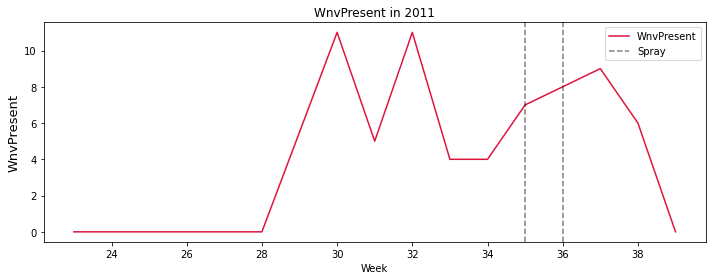

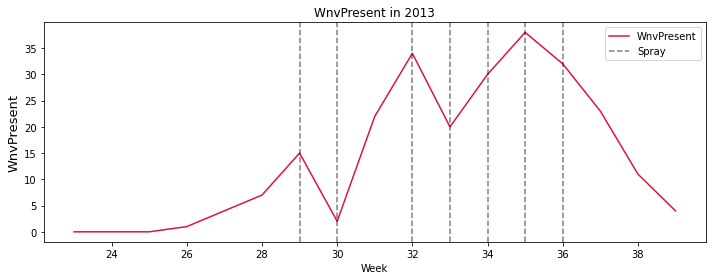

In [ ]:
# Spraying don't seem to have a clear/immediate effect on WNV found within traps
target_plot('WnvPresent', 'crimson')

It's hard to fully gauge the effects of the spraying based on our current data, but it seems that the spraying is helping to keep the mosquito population in control.

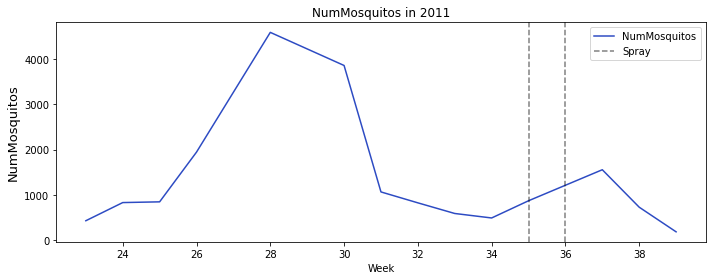

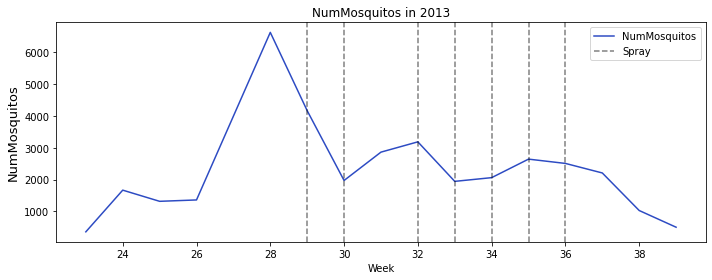

In [ ]:
# These sprays seem to have a limited effect on number of mosquitos found in traps
target_plot('NumMosquitos', '#2d4bc3')